# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    preoutput_layer = separable_conv2d_batchnorm(concatenated_layer, filters)
    output_layer = separable_conv2d_batchnorm(preoutput_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    f = 32
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_layer1 = encoder_block(inputs, f, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 2*f, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 4*f, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    mid_layer = conv2d_batchnorm(encoder_layer3, 4*f ,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_layer1 = decoder_block(mid_layer, encoder_layer2, 4*f)
    decoder_layer2 = decoder_block(decoder_layer1, encoder_layer1, 2*f)
    decoder_layer3 = decoder_block(decoder_layer2, inputs, f)
    
    # The function returns the output layer of your model
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_layer3)
    
    # Print network shapes
    print(inputs)
    print(encoder_layer1)
    print(encoder_layer2)
    print(encoder_layer3)
    print(mid_layer)
    print(decoder_layer1)
    print(decoder_layer2)
    print(decoder_layer3)
    print(outputs)
    
    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 160, 160, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 80, 80, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 40, 40, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 40, 40, 128), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 80, 80, 64), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 160, 160, 32), dtype=float32)
Tensor("conv2d_2/truediv:0", shape=(?, 160, 160, 3), dtype=float32)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
number_of_validation_images = 1184
number_of_training_images = 4600 

learning_rate = 0.0001
num_epochs = 70
batch_size = 40
steps_per_epoch = number_of_training_images // batch_size + 1
validation_steps = number_of_validation_images // batch_size + 1
workers = 10

print("steps per epoch: ", steps_per_epoch)
print("validation steps: ", validation_steps)

steps per epoch:  116
validation steps:  30


Epoch 1/70
115/116 [============================>.] - ETA: 0s - loss: 1.1821

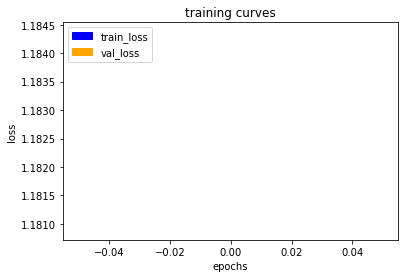

116/116 [==============================] - 88s - loss: 1.1809 - val_loss: 1.1844
Epoch 2/70
115/116 [============================>.] - ETA: 0s - loss: 0.9981

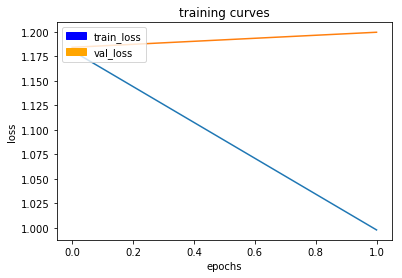

116/116 [==============================] - 84s - loss: 0.9977 - val_loss: 1.1998
Epoch 3/70
115/116 [============================>.] - ETA: 0s - loss: 0.9030

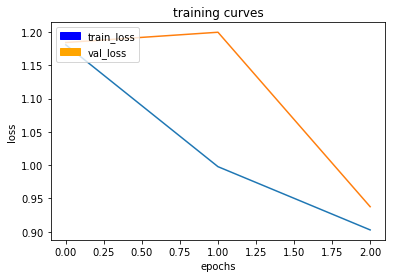

116/116 [==============================] - 84s - loss: 0.9026 - val_loss: 0.9375
Epoch 4/70
115/116 [============================>.] - ETA: 0s - loss: 0.8003

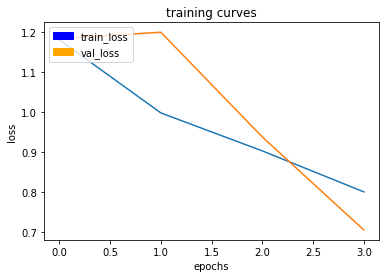

116/116 [==============================] - 84s - loss: 0.8001 - val_loss: 0.7047
Epoch 5/70
115/116 [============================>.] - ETA: 0s - loss: 0.6989

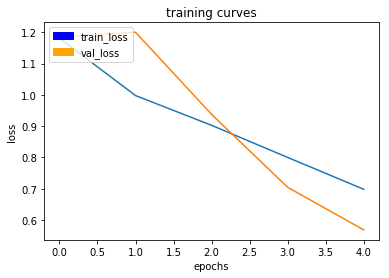

116/116 [==============================] - 84s - loss: 0.6984 - val_loss: 0.5687
Epoch 6/70
115/116 [============================>.] - ETA: 0s - loss: 0.5978

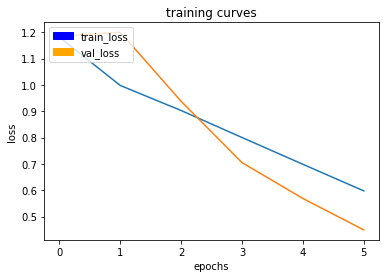

116/116 [==============================] - 84s - loss: 0.5974 - val_loss: 0.4493
Epoch 7/70
115/116 [============================>.] - ETA: 0s - loss: 0.5050

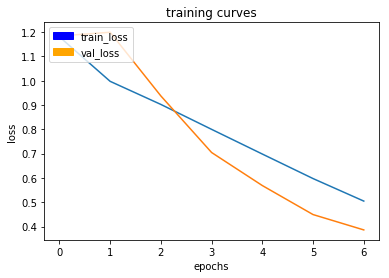

116/116 [==============================] - 84s - loss: 0.5047 - val_loss: 0.3861
Epoch 8/70
115/116 [============================>.] - ETA: 0s - loss: 0.4242

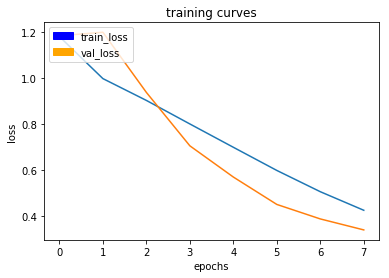

116/116 [==============================] - 84s - loss: 0.4238 - val_loss: 0.3382
Epoch 9/70
115/116 [============================>.] - ETA: 0s - loss: 0.3551

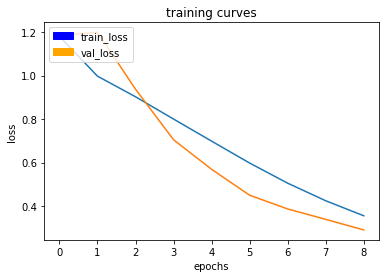

116/116 [==============================] - 84s - loss: 0.3547 - val_loss: 0.2896
Epoch 10/70
115/116 [============================>.] - ETA: 0s - loss: 0.2989

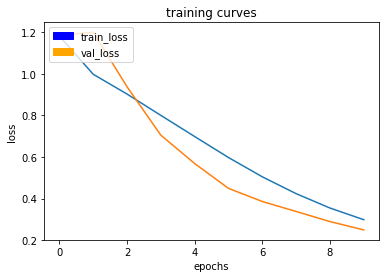

116/116 [==============================] - 84s - loss: 0.2986 - val_loss: 0.2495
Epoch 11/70
115/116 [============================>.] - ETA: 0s - loss: 0.2526

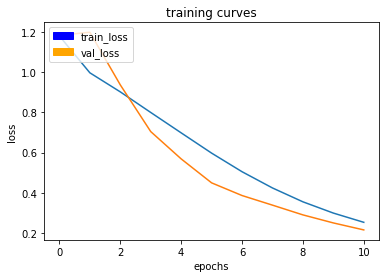

116/116 [==============================] - 84s - loss: 0.2526 - val_loss: 0.2147
Epoch 12/70
115/116 [============================>.] - ETA: 0s - loss: 0.2132

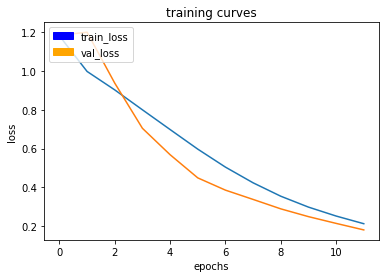

116/116 [==============================] - 85s - loss: 0.2130 - val_loss: 0.1811
Epoch 13/70
115/116 [============================>.] - ETA: 0s - loss: 0.1847

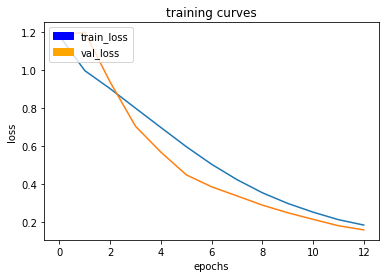

116/116 [==============================] - 84s - loss: 0.1845 - val_loss: 0.1590
Epoch 14/70
115/116 [============================>.] - ETA: 0s - loss: 0.1592

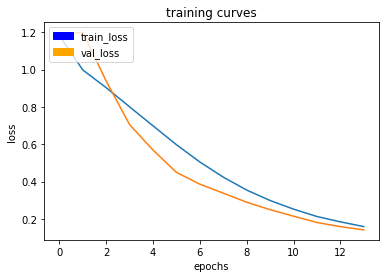

116/116 [==============================] - 83s - loss: 0.1591 - val_loss: 0.1413
Epoch 15/70
115/116 [============================>.] - ETA: 0s - loss: 0.1397

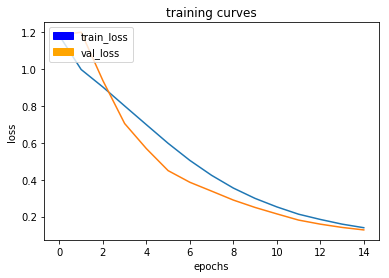

116/116 [==============================] - 85s - loss: 0.1397 - val_loss: 0.1277
Epoch 16/70
115/116 [============================>.] - ETA: 0s - loss: 0.1244

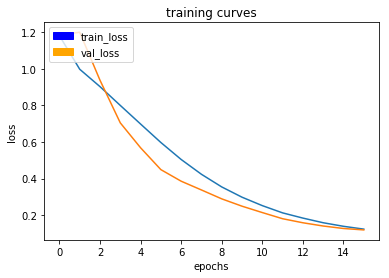

116/116 [==============================] - 83s - loss: 0.1243 - val_loss: 0.1200
Epoch 17/70
115/116 [============================>.] - ETA: 0s - loss: 0.1103

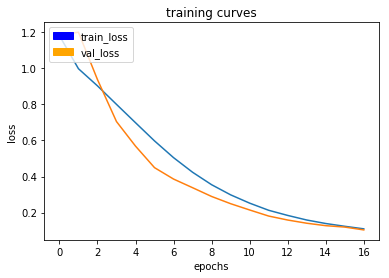

116/116 [==============================] - 84s - loss: 0.1102 - val_loss: 0.1042
Epoch 18/70
115/116 [============================>.] - ETA: 0s - loss: 0.1004

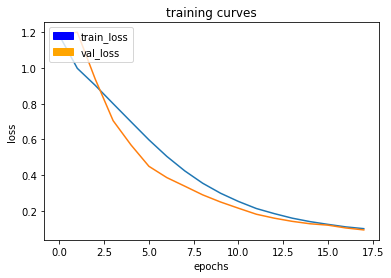

116/116 [==============================] - 84s - loss: 0.1003 - val_loss: 0.0933
Epoch 19/70
115/116 [============================>.] - ETA: 0s - loss: 0.0899

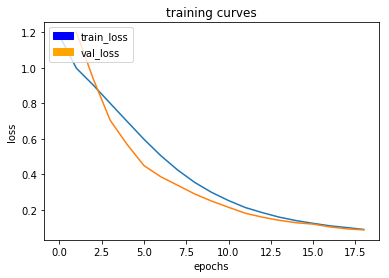

116/116 [==============================] - 84s - loss: 0.0898 - val_loss: 0.0873
Epoch 20/70
115/116 [============================>.] - ETA: 0s - loss: 0.0825

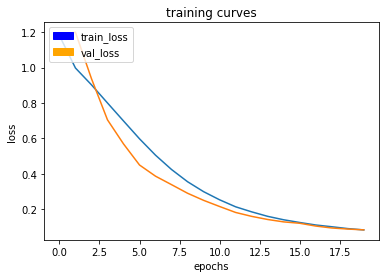

116/116 [==============================] - 84s - loss: 0.0824 - val_loss: 0.0827
Epoch 21/70
115/116 [============================>.] - ETA: 0s - loss: 0.0775

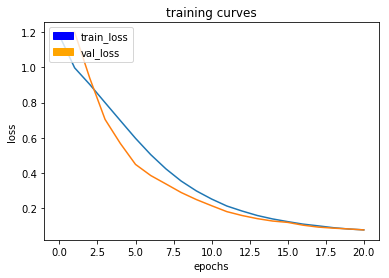

116/116 [==============================] - 84s - loss: 0.0774 - val_loss: 0.0772
Epoch 22/70
115/116 [============================>.] - ETA: 0s - loss: 0.0702

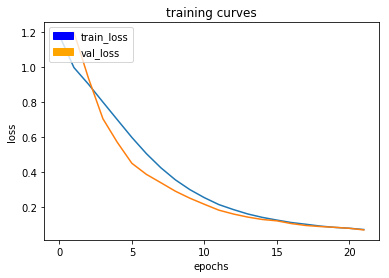

116/116 [==============================] - 84s - loss: 0.0701 - val_loss: 0.0679
Epoch 23/70
115/116 [============================>.] - ETA: 0s - loss: 0.0674

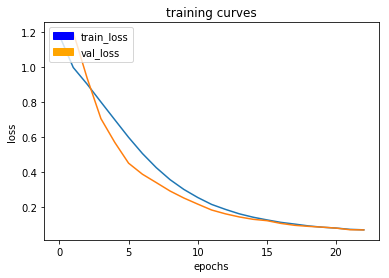

116/116 [==============================] - 85s - loss: 0.0674 - val_loss: 0.0669
Epoch 24/70
115/116 [============================>.] - ETA: 0s - loss: 0.0623

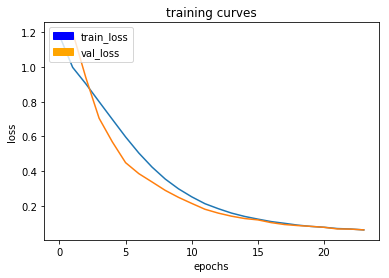

116/116 [==============================] - 84s - loss: 0.0622 - val_loss: 0.0624
Epoch 25/70
115/116 [============================>.] - ETA: 0s - loss: 0.0594

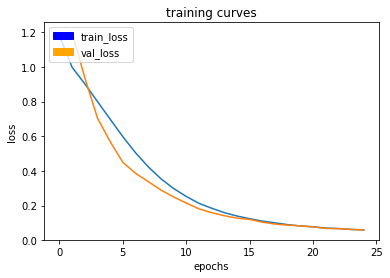

116/116 [==============================] - 84s - loss: 0.0595 - val_loss: 0.0595
Epoch 26/70
115/116 [============================>.] - ETA: 0s - loss: 0.0558

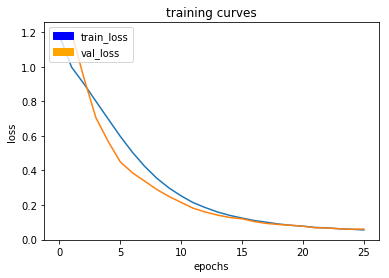

116/116 [==============================] - 84s - loss: 0.0557 - val_loss: 0.0607
Epoch 27/70
115/116 [============================>.] - ETA: 0s - loss: 0.0544

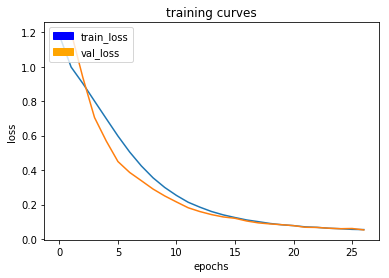

116/116 [==============================] - 84s - loss: 0.0544 - val_loss: 0.0525
Epoch 28/70
115/116 [============================>.] - ETA: 0s - loss: 0.0505

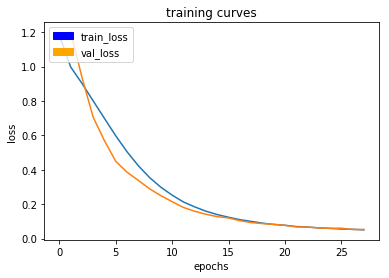

116/116 [==============================] - 84s - loss: 0.0505 - val_loss: 0.0537
Epoch 29/70
115/116 [============================>.] - ETA: 0s - loss: 0.0498

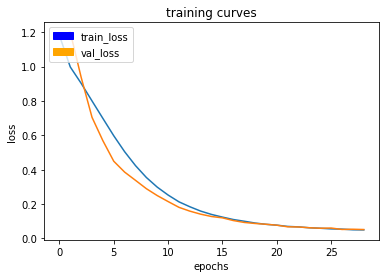

116/116 [==============================] - 83s - loss: 0.0498 - val_loss: 0.0520
Epoch 30/70
115/116 [============================>.] - ETA: 0s - loss: 0.0471

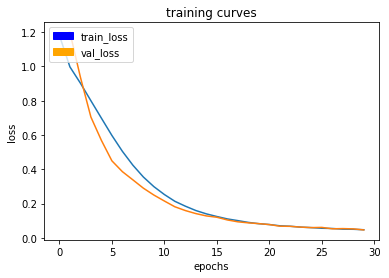

116/116 [==============================] - 84s - loss: 0.0470 - val_loss: 0.0460
Epoch 31/70
115/116 [============================>.] - ETA: 0s - loss: 0.0456

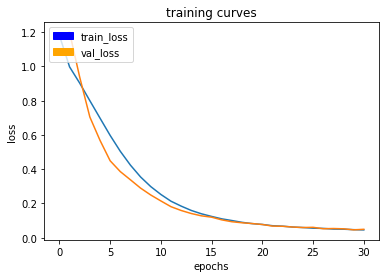

116/116 [==============================] - 84s - loss: 0.0456 - val_loss: 0.0491
Epoch 32/70
115/116 [============================>.] - ETA: 0s - loss: 0.0437

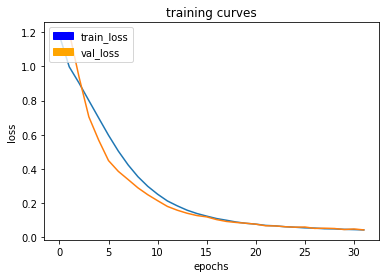

116/116 [==============================] - 84s - loss: 0.0437 - val_loss: 0.0438
Epoch 33/70
115/116 [============================>.] - ETA: 0s - loss: 0.0426

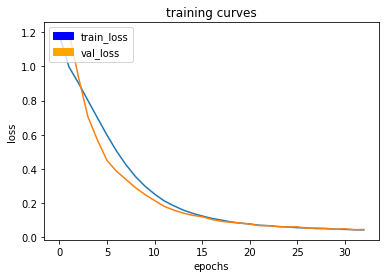

116/116 [==============================] - 85s - loss: 0.0426 - val_loss: 0.0452
Epoch 34/70
115/116 [============================>.] - ETA: 0s - loss: 0.0412

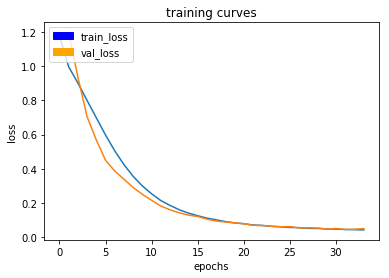

116/116 [==============================] - 84s - loss: 0.0412 - val_loss: 0.0492
Epoch 35/70
115/116 [============================>.] - ETA: 0s - loss: 0.0407

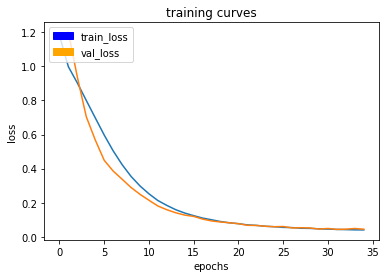

116/116 [==============================] - 84s - loss: 0.0408 - val_loss: 0.0450
Epoch 36/70
115/116 [============================>.] - ETA: 0s - loss: 0.0390

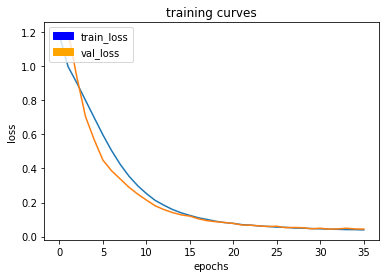

116/116 [==============================] - 84s - loss: 0.0392 - val_loss: 0.0442
Epoch 37/70
115/116 [============================>.] - ETA: 0s - loss: 0.0378

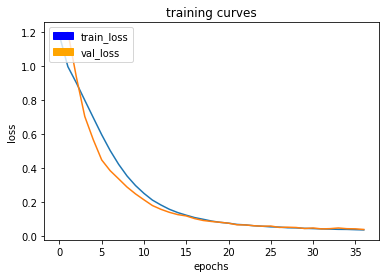

116/116 [==============================] - 84s - loss: 0.0378 - val_loss: 0.0404
Epoch 38/70
115/116 [============================>.] - ETA: 0s - loss: 0.0362

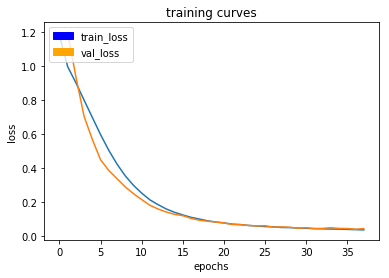

116/116 [==============================] - 84s - loss: 0.0361 - val_loss: 0.0438
Epoch 39/70
115/116 [============================>.] - ETA: 0s - loss: 0.0364

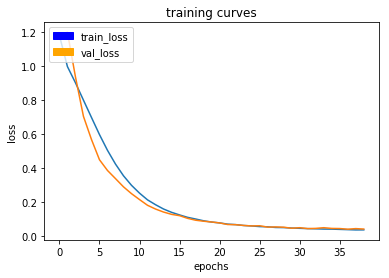

116/116 [==============================] - 84s - loss: 0.0364 - val_loss: 0.0412
Epoch 40/70
115/116 [============================>.] - ETA: 0s - loss: 0.0357

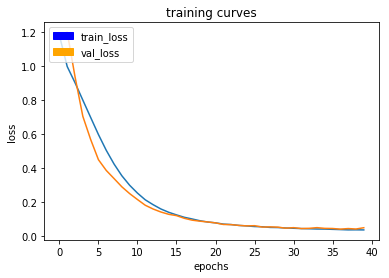

116/116 [==============================] - 84s - loss: 0.0358 - val_loss: 0.0487
Epoch 41/70
115/116 [============================>.] - ETA: 0s - loss: 0.0337

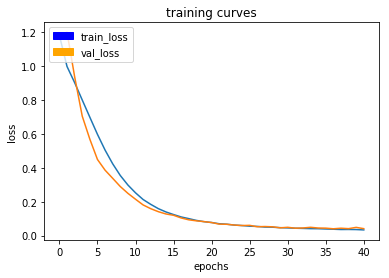

116/116 [==============================] - 84s - loss: 0.0337 - val_loss: 0.0412
Epoch 42/70
115/116 [============================>.] - ETA: 0s - loss: 0.0338

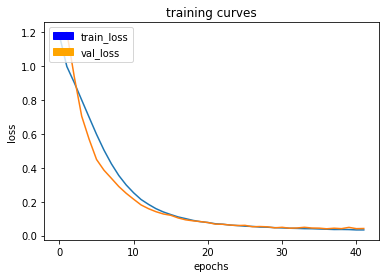

116/116 [==============================] - 85s - loss: 0.0337 - val_loss: 0.0421
Epoch 43/70
115/116 [============================>.] - ETA: 0s - loss: 0.0314

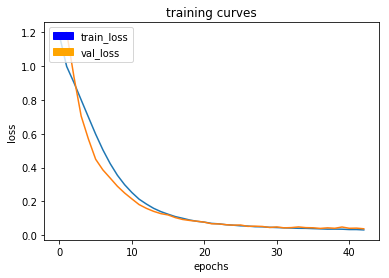

116/116 [==============================] - 84s - loss: 0.0315 - val_loss: 0.0383
Epoch 44/70
115/116 [============================>.] - ETA: 0s - loss: 0.0327

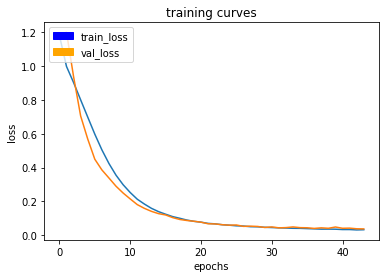

116/116 [==============================] - 84s - loss: 0.0327 - val_loss: 0.0375
Epoch 45/70
115/116 [============================>.] - ETA: 0s - loss: 0.0317

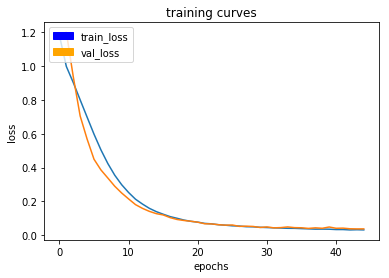

116/116 [==============================] - 83s - loss: 0.0316 - val_loss: 0.0377
Epoch 46/70
115/116 [============================>.] - ETA: 0s - loss: 0.0309

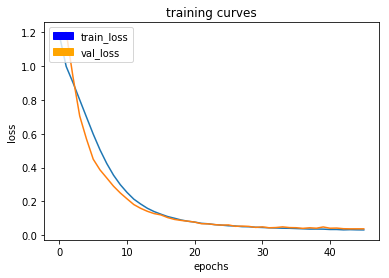

116/116 [==============================] - 84s - loss: 0.0312 - val_loss: 0.0377
Epoch 47/70
115/116 [============================>.] - ETA: 0s - loss: 0.0319

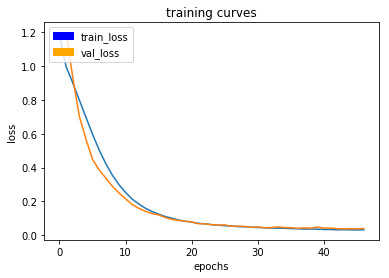

116/116 [==============================] - 83s - loss: 0.0318 - val_loss: 0.0392
Epoch 48/70
115/116 [============================>.] - ETA: 0s - loss: 0.0295

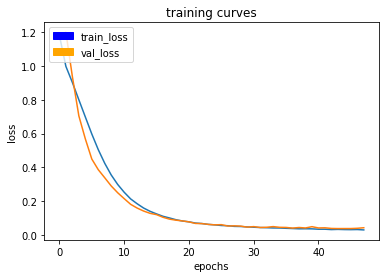

116/116 [==============================] - 84s - loss: 0.0295 - val_loss: 0.0425
Epoch 49/70
115/116 [============================>.] - ETA: 0s - loss: 0.0298

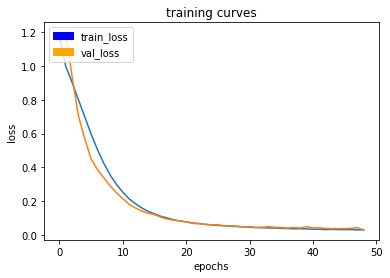

116/116 [==============================] - 83s - loss: 0.0298 - val_loss: 0.0300
Epoch 50/70
115/116 [============================>.] - ETA: 0s - loss: 0.0280

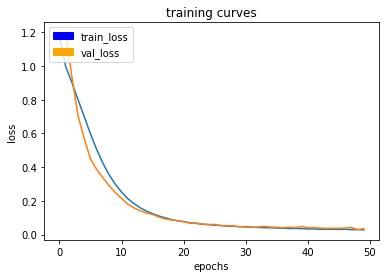

116/116 [==============================] - 84s - loss: 0.0279 - val_loss: 0.0356
Epoch 51/70
115/116 [============================>.] - ETA: 0s - loss: 0.0293

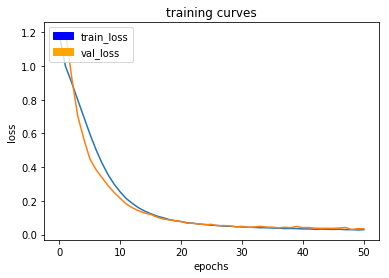

116/116 [==============================] - 84s - loss: 0.0293 - val_loss: 0.0350
Epoch 52/70
115/116 [============================>.] - ETA: 0s - loss: 0.0284

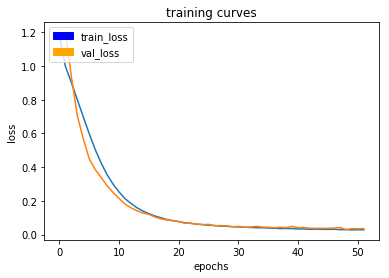

116/116 [==============================] - 84s - loss: 0.0283 - val_loss: 0.0356
Epoch 53/70
115/116 [============================>.] - ETA: 0s - loss: 0.0270

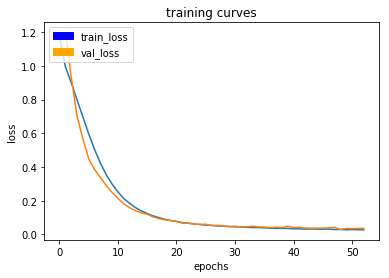

116/116 [==============================] - 84s - loss: 0.0270 - val_loss: 0.0366
Epoch 54/70
115/116 [============================>.] - ETA: 0s - loss: 0.0281

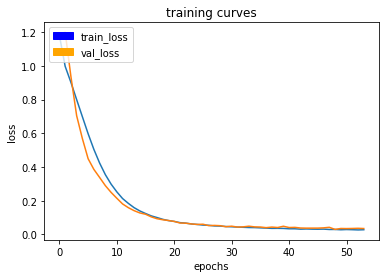

116/116 [==============================] - 84s - loss: 0.0281 - val_loss: 0.0352
Epoch 55/70
115/116 [============================>.] - ETA: 0s - loss: 0.0269

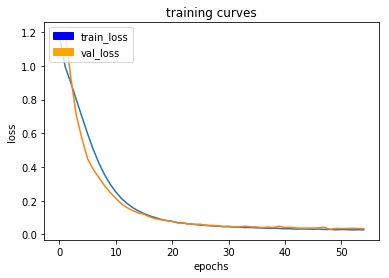

116/116 [==============================] - 84s - loss: 0.0268 - val_loss: 0.0344
Epoch 56/70
115/116 [============================>.] - ETA: 0s - loss: 0.0263

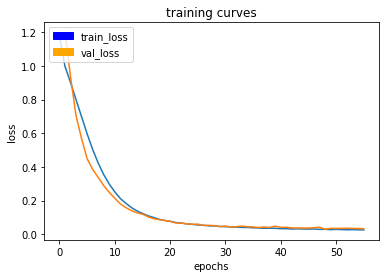

116/116 [==============================] - 84s - loss: 0.0263 - val_loss: 0.0336
Epoch 57/70
115/116 [============================>.] - ETA: 0s - loss: 0.0267

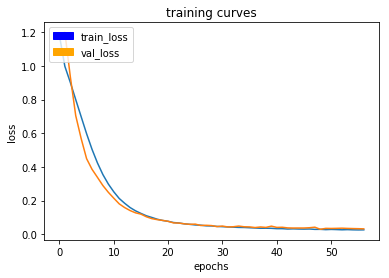

116/116 [==============================] - 84s - loss: 0.0267 - val_loss: 0.0327
Epoch 58/70
115/116 [============================>.] - ETA: 0s - loss: 0.0250

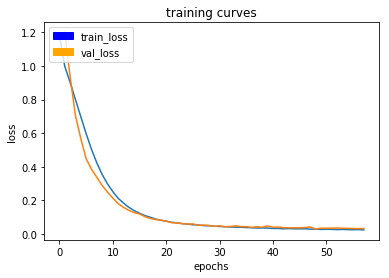

116/116 [==============================] - 84s - loss: 0.0250 - val_loss: 0.0335
Epoch 59/70
115/116 [============================>.] - ETA: 0s - loss: 0.0268

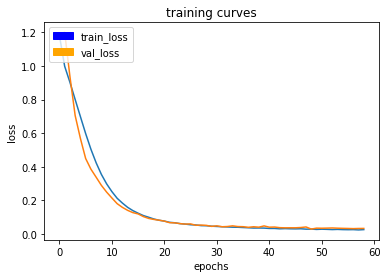

116/116 [==============================] - 84s - loss: 0.0268 - val_loss: 0.0338
Epoch 60/70
115/116 [============================>.] - ETA: 0s - loss: 0.0258

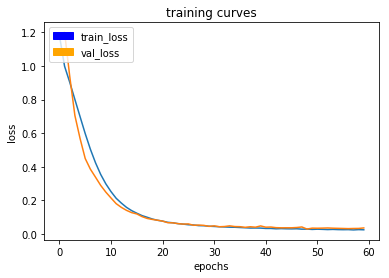

116/116 [==============================] - 85s - loss: 0.0257 - val_loss: 0.0368
Epoch 61/70
115/116 [============================>.] - ETA: 0s - loss: 0.0251

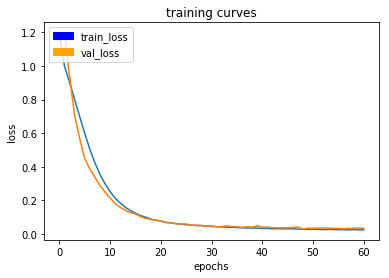

116/116 [==============================] - 84s - loss: 0.0251 - val_loss: 0.0340
Epoch 62/70
115/116 [============================>.] - ETA: 0s - loss: 0.0251

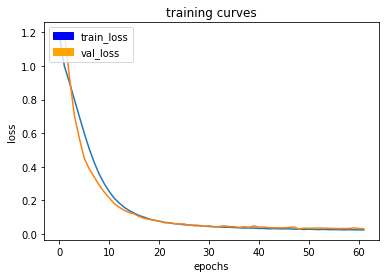

116/116 [==============================] - 84s - loss: 0.0251 - val_loss: 0.0319
Epoch 63/70
115/116 [============================>.] - ETA: 0s - loss: 0.0245

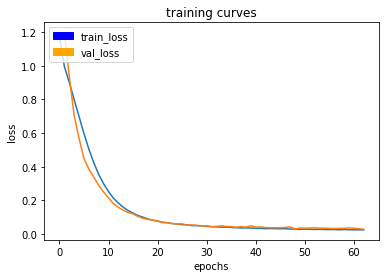

116/116 [==============================] - 84s - loss: 0.0245 - val_loss: 0.0283
Epoch 64/70
115/116 [============================>.] - ETA: 0s - loss: 0.0242

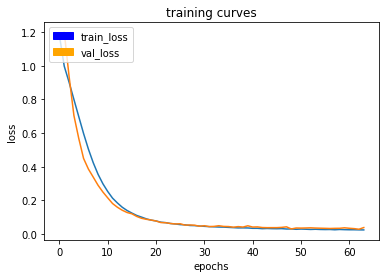

116/116 [==============================] - 84s - loss: 0.0242 - val_loss: 0.0382
Epoch 65/70
115/116 [============================>.] - ETA: 0s - loss: 0.0254

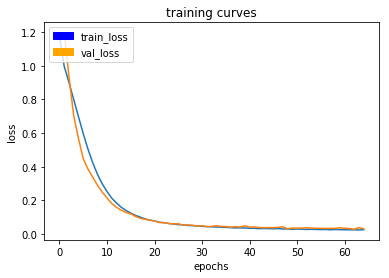

116/116 [==============================] - 84s - loss: 0.0254 - val_loss: 0.0297
Epoch 66/70
115/116 [============================>.] - ETA: 0s - loss: 0.0234

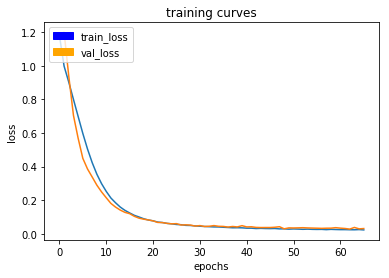

116/116 [==============================] - 84s - loss: 0.0234 - val_loss: 0.0315
Epoch 67/70
115/116 [============================>.] - ETA: 0s - loss: 0.0232

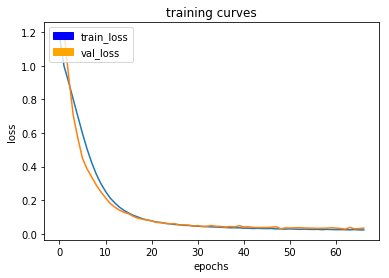

116/116 [==============================] - 84s - loss: 0.0234 - val_loss: 0.0340
Epoch 68/70
115/116 [============================>.] - ETA: 0s - loss: 0.0235

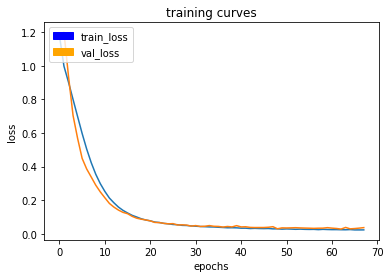

116/116 [==============================] - 84s - loss: 0.0235 - val_loss: 0.0370
Epoch 69/70
115/116 [============================>.] - ETA: 0s - loss: 0.0237

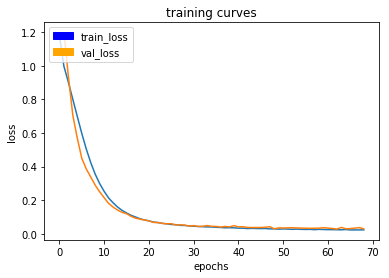

116/116 [==============================] - 84s - loss: 0.0237 - val_loss: 0.0296
Epoch 70/70
115/116 [============================>.] - ETA: 0s - loss: 0.0227

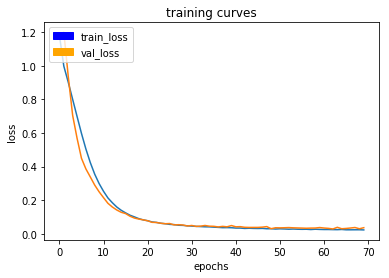

116/116 [==============================] - 84s - loss: 0.0227 - val_loss: 0.0359


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

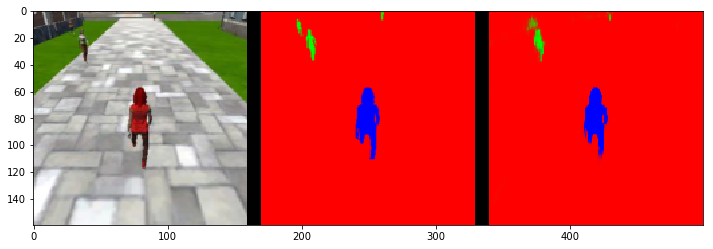

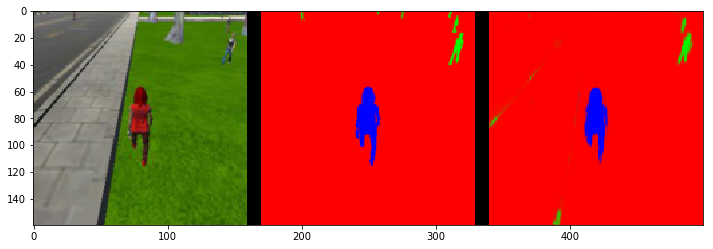

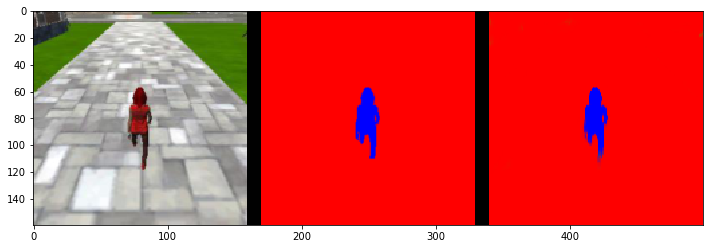

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

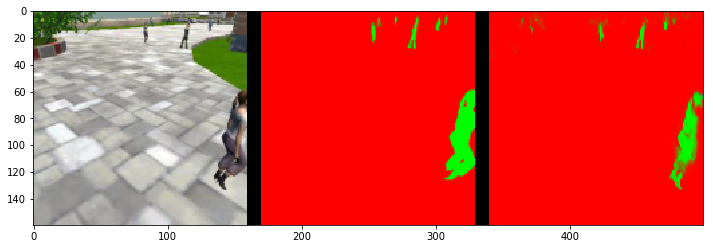

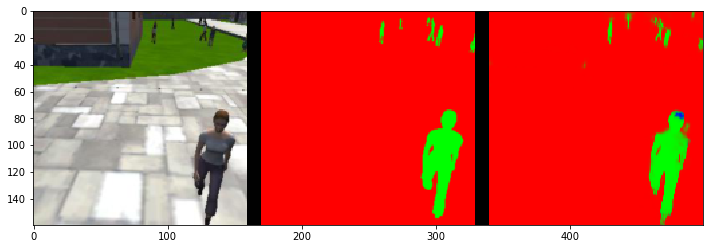

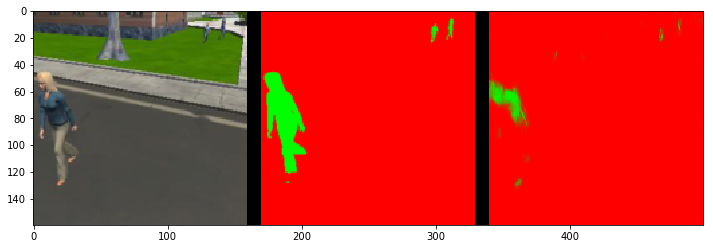

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

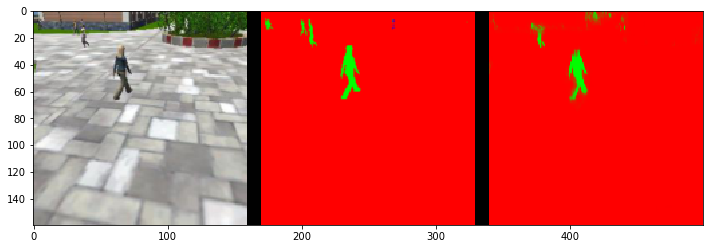

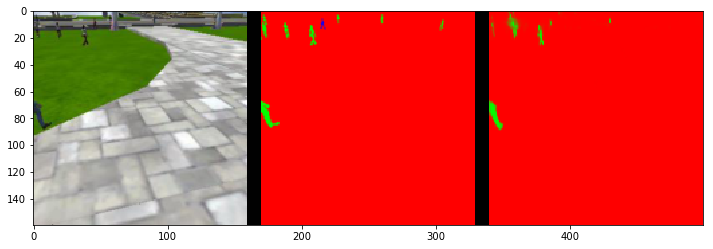

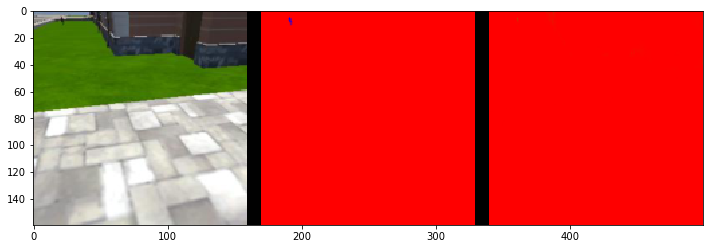

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [27]:
os.chdir("/home/ubuntu/RoboND-DeepLearning-Project/code/")

# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9938429831453963
average intersection over union for other people is 0.2626821716280214
average intersection over union for the hero is 0.8813720883745416
number true positives: 539, number false positives: 0, number false negatives: 0


In [28]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9804036277889877
average intersection over union for other people is 0.5829291138941562
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 89, number false negatives: 0


In [29]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9947193631851393
average intersection over union for other people is 0.3362878994816512
average intersection over union for the hero is 0.09343828939634863
number true positives: 71, number false positives: 1, number false negatives: 230


In [30]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6559139784946236


In [31]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.487405188885


In [32]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.319695876581


In [36]:
img_dir = "/home/ubuntu/RoboND-DeepLearning-Project/data/train/masks"
total_files, total_hero = 0, 0
os.chdir(img_dir)
for file in glob.glob("*.png"):
  total_files +=1
  img = misc.imread(file, flatten=False, mode='RGB')
  blue = img[:,:,2]

  if np.any(blue == 255):
    total_hero += 1

percent_hero = 100. * total_hero / total_files

print (percent_hero, "percent of files contain the hero")

27.608695652173914 percent of files contain the hero
